In [201]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
def read_data():
    used_data = pd.read_csv('../data/data.csv', index_col=0, parse_dates=True)

    # Prices and returns
    S = np.exp(used_data.fillna(0)).cumprod()
    ret_day = used_data.fillna(0)
    ret_mon = S.resample('1BM').ffill().pct_change()
    ret_mon['median_t+1'] = ret_mon.median(1).shift(-1)
    ret_mon = ret_mon.dropna()

    # 1 for winner, 0 for loser
    labels = ret_mon[ret_mon.columns[:-1]].gt(ret_mon['median_t+1'], axis=0).astype(int)
    ret_mon['JAN'] = (ret_mon.index.month == 1).astype(int)
    ret_mon = ret_mon.reset_index()

    # update column names after index reset
    cols = ret_mon.columns.values
    cols[0] = 'date'
    ret_mon.columns = cols
    return labels, ret_mon, ret_day, used_data

def get_data(limit_tic=None):
    labels, ret_mon, ret_day, used_data = read_data()
    
    final_data = []
    if limit_tic:
        tickers = [limit_tic]
    else:
        tickers = used_data.columns
    for tic in tickers:
        daily = ret_day[tic]
        dfs = []
        for t in range(13, len(ret_mon)-1):
            current_y = ret_mon['date'].iloc[t].year
            current_mon = ret_mon['date'].iloc[t].month

            start = t - 13
            end = t - 2

            ret_mon_slice = ret_mon[tic].iloc[start:end+1]
            ret_mon_next = ret_mon[tic].iloc[t+1]
            jan = ret_mon.JAN.iloc[t]
            label = labels[tic].iloc[t]

            last_date = (daily[(daily.index.year == current_y) 
                               & (daily.index.month == current_mon)].last_valid_index())

            last_date_loc = daily.index.get_loc(last_date)
            start_date_loc = last_date_loc - 19

            daily_rets_slice = daily.iloc[start_date_loc:last_date_loc + 1]

            daily_rets_slice.index = ['R_d_' + str(i) for i in range(1, 21)]
            ret_mon_slice.index = ['R_m_' + str(i) for i in range(1, 13)]

            conc = pd.concat([daily_rets_slice, ret_mon_slice])
            conc['jan'] = jan
            conc['label'] = label
            conc['n_return'] = ret_mon_next
            conc = conc.to_frame()
            conc.columns = [t]
            dfs.append(conc)
        feats = pd.concat(dfs, axis=1).T
        final_data.append(feats)
        
    return pd.concat(final_data, axis=0)

In [3]:
def data_importer(fname, train_set_size=0.75):
    data = get_data()
    X = data[data.columns[:-2]].as_matrix()
    y = data.label.as_matrix()
    
    N = len(y)
    train_set_stop = int(N * train_set_size)
    
    return X[0:train_set_stop], y[0: train_set_stop], X[train_set_stop:], y[train_set_stop:]

In [4]:
class FutureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(33, 50)
        self.fc21 = nn.Linear(50, 4)
        self.fc22 = nn.Linear(50, 4)
        self.fc3 = nn.Linear(4, 50)
        self.fc4 = nn.Linear(50, 33)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = Variable(torch.rand(std.size()).cuda(), requires_grad=False)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 33))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        
    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x.view(-1, 33), size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD

In [6]:
Xtrain, ytrain, Xtest, ytest = data_importer("./data/ES_w_features.csv")

batch_size = 64
train_dataset = FutureDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = FutureDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [34]:
log_interval = 100
number_of_epochs = 500

In [35]:
vae = VAE().cuda()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [36]:
vae.train()
for epoch in range(number_of_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.float().cuda())
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
    
    if (epoch+1) % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


====> Epoch: 99 Average loss: 0.0690
====> Epoch: 199 Average loss: 0.0589
====> Epoch: 299 Average loss: 0.0560
====> Epoch: 399 Average loss: 0.0557
====> Epoch: 499 Average loss: 0.0540


In [37]:
vae.eval()
test_loss = 0
for i, (data, _) in enumerate(test_loader):
    data = Variable(data.float().cuda(), requires_grad=False)
    recon_batch, mu, logvar = vae(data)
    test_loss += vae.loss_function(recon_batch, data, mu, logvar).data[0]

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 0.0903


In [38]:
# Build encoded dataset
Xenc = np.array([]).reshape(0, 4)
yenc = np.array([])
for _, (data,target) in enumerate(train_loader):
    data = Variable(data.view(-1,33)).float().cuda()
    labels = Variable(target).type(torch.LongTensor).cuda()
    
    _, data, _ = vae(data)
    
    batch = data.cpu().data.numpy()
    Xenc = np.vstack((Xenc, batch))
    yenc = np.append(yenc, target.numpy())


In [42]:
# RANDOM FOREST CLASSIFIER
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(Xenc, yenc)
score = cross_val_score(clf, Xenc, yenc)
print(score.mean())

print("What features are prefered", clf.feature_importances_)

0.5254559855668742
What features are prefered [0.27836424 0.15803244 0.24506397 0.31853935]


In [33]:
# NAIVE BAYESIAN CLASSIFIER
gnb = GaussianNB()
gnb.fit(Xenc, yenc)
score = cross_val_score(clf, Xenc, yenc)
print(score.mean())

0.5497532140840319


In [ ]:
# ORGINAL DATA
feats = get_data()
Xorg = feats[feats.columns[:-2]].as_matrix()
yorg = feats.label.as_matrix()

In [258]:
# RANDOM FOREST CLASSIFIER ONLY
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(Xorg, yorg)
score = cross_val_score(clf, Xorg, yorg)
print(score.mean())

print("What features are prefered: \n", clf.feature_importances_)

0.6964769343589986
What features are prefered: 
 [0.02446595 0.03578831 0.05075668 0.04026523 0.06575179 0.02737047
 0.05918574 0.03365722 0.0386964  0.03484094 0.02307217 0.04419881
 0.04075479 0.03113584 0.02713435 0.02175224 0.02413381 0.02301962
 0.03667414 0.02251901 0.02531896 0.01890272 0.02758396 0.02247491
 0.02312466 0.02437588 0.02460995 0.02480353 0.02802854 0.02939102
 0.01953101 0.02575543 0.00092589]


In [241]:
# ADABOOST ONLY
ada = AdaBoostClassifier(n_estimators=10)
ada.fit(Xorg, yorg)  
score = cross_val_score(ada, Xorg, yorg)
print(score.mean())

0.6309750090944672


In [181]:
svc = SVC(gamma=2, C=1)
svc.fit(Xorg, yorg)
score = cross_val_score(ada, Xorg, yorg)
print(score.mean())

0.7262989879924914


In [136]:
# PREDICTION RESULTS FROM ENCODER PIPELINE
prediction_outputs = []
returns = []

classifier = clf

for idx, observation in enumerate(Xorg):
    data = torch.from_numpy(observation)

    data = Variable(data).float().cuda()
    _, data, _ = vae(data)
    output = classifier.predict_proba(data.cpu().data.numpy())
    prediction_outputs.append(output[0])

len(prediction_outputs)

In [221]:
def get_result_df(prediction_outputs, feats):
    result_df = pd.DataFrame(prediction_outputs, columns=["loser_p", "winner_p"])
    result_df["label"] = (result_df["winner_p"] < result_df["loser_p"]).astype(int)
    feats = feats.reset_index()
    result_df["n_return"] = feats.n_return
    result_df["longshort"] = result_df["label"].map({1: 1, 0: -1})
    result_df["position_return"] = result_df["longshort"] * result_df["n_return"]

    print("Predicted long count:", sum(result_df["label"]))

    return result_df

In [259]:
labels, ret_mon, ret_day, used_data = read_data()

position_returns = pd.DataFrame()
for tic in ["ES", "FESX", "GC", "NK", "TU", "ED"]:
    feats = get_data(tic)
    X = feats[feats.columns[:-2]].as_matrix()
    #prediction_outputs = np.column_stack((1 - mlpc.predict(X), 0 + mlpc.predict(X)))
    prediction_outputs = clf.predict_proba(X)
    df = get_result_df(prediction_outputs, feats)
    position_returns[tic] = df["position_return"]
    


Predicted long count: 86
Predicted long count: 83
Predicted long count: 93
Predicted long count: 94
Predicted long count: 112
Predicted long count: 119


In [260]:
# Add more columns
position_returns["monthly_avg"] = position_returns.mean(axis=1)
position_returns["monthly_avg_cum"] = (position_returns["monthly_avg"]+1).cumprod() - 1

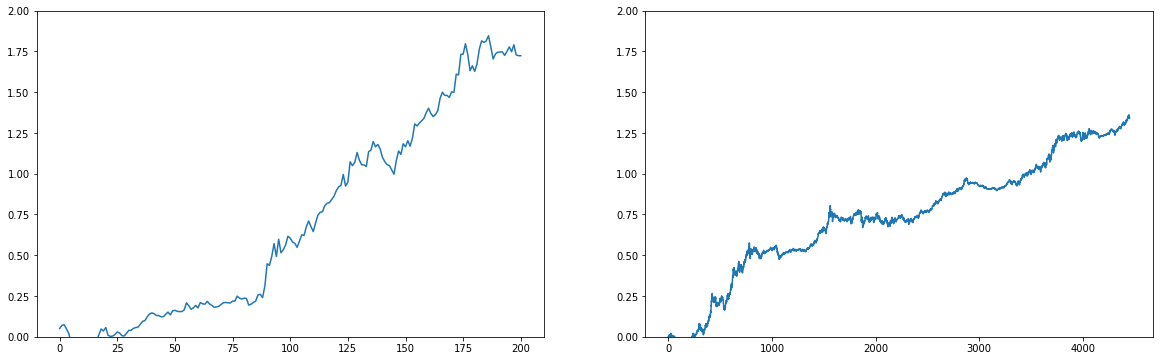

In [261]:
plt.figure(figsize=(20, 6))

# MOTHLY AVG PLOT
plt.subplot(1, 2, 1)
plt.ylim([0,2])
position_returns["monthly_avg_cum"].plot()

# DAILY JUHIS
plt.subplot(1, 2, 2)
plt.ylim([0,2])
juhis_df = pd.read_csv('../data/benchmark.csv', parse_dates=False)
juhis_df["Returns"].plot()

In [262]:
# Sharpe
print("Mean: ", position_returns["monthly_avg"].mean())
print("Std: ", position_returns["monthly_avg"].std())
sharpe = position_returns["monthly_avg"].mean() / position_returns["monthly_avg"].std()
print("Sharpe: ", sharpe)


print("Mean: ", juhis_df["Returns"].mean())
print("Std: ", juhis_df["Returns"].std())
sharpe = juhis_df["Returns"].mean() / juhis_df["Returns"].std()
print("Sharpe: ", sharpe)

Mean:  0.0052330364398436545
Std:  0.021883394431437633
Sharpe:  0.2391327568599635
Mean:  0.7399423283186392
Std:  0.3556731556698301
Sharpe:  2.0803997055249357
